<a href="https://colab.research.google.com/github/albert-yue/6864-hw1/blob/master/6864_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf 6864-hw1
git clone https://github.com/lingo-mit/6864-hw1.git

Cloning into '6864-hw1'...


In [0]:
import sys
sys.path.append("/content/6864-hw1")

import csv
import itertools as it
import numpy as np
np.random.seed(0)

import lab_util

In [0]:
from matplotlib import pyplot as plt
from google.colab import files

## Introduction

In this lab, you'll explore three different ways of using unlabeled text data to learn pretrained word representations. Your lab report will describe the effects of different modeling decisions (representation learning objective, context size, etc.) on both qualitative properties of learned representations and their effect on a downstream prediction problem.

**General lab report guidelines**

Homework assignments should be submitted in the form of a research report. (We'll be providing a place to upload them before the due date, but are still sorting out some logistics.) Please upload PDFs, with a maximum of four single-spaced pages. (If you want you can use the [Association for Computational Linguistics style files](http://acl2020.org/downloads/acl2020-templates.zip).) Reports should have one section for each part of the homework assignment below. Each section should describe the details of your code implementation, and include whatever charts / tables are necessary to answer the set of questions at the end of the corresponding homework part.



We're going to be working with a dataset of product reviews. It looks like this:

In [3]:
data = []
n_positive = 0
n_disp = 0
with open("/content/6864-hw1/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue
      n_positive += 1
    if len(data) == 4000:
      break

    data.append((review, label))
    
    if n_disp > 5:
      continue
    n_disp += 1
    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")
np.random.shuffle(data)
reviews, labels = zip(*data)
train_reviews = reviews[:3000]
train_labels = labels[:3000]
val_reviews = reviews[3000:3500]
val_labels = labels[3000:3500]
test_reviews = reviews[3500:]
test_labels = labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

We've provided a little bit of helper code for reading in the dataset; your job is to implement the learning!

## Part 1: word representations via matrix factorization

First, we'll construct the term--document matrix (look at `/content/6864-hw1/lab_util.py` in the file browser on the left if you want to see how this works).

In [4]:
vectorizer = lab_util.CountVectorizer()
vectorizer.fit(train_reviews)
td_matrix = vectorizer.transform(train_reviews).T
print(f"TD matrix is {td_matrix.shape[0]} x {td_matrix.shape[1]}")

TD matrix is 2006 x 3000


First, implement a function that computes word representations via latent semantic analysis:

In [0]:
from numpy.linalg import svd

def learn_reps_lsa(matrix, rep_size):
  # `matrix` is a `|V| x n` matrix, where `|V|` is the number of words in the
  # vocabulary. This function should return a `|V| x rep_size` matrix with each
  # row corresponding to a word representation. The `sklearn.decomposition` 
  # package may be useful.

  u, _, _ = svd(matrix)
  return u[:, :rep_size]

Let's look at some representations:

In [6]:
reps = learn_reps_lsa(td_matrix, 500)
words = ["good", "bad", "cookie", "jelly", "dog", "the", "4"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

good 47
  gerber 1.873
  luck 1.885
  crazy 1.890
  flaxseed 1.906
  suspect 1.907
bad 201
  disgusting 1.625
  horrible 1.776
  shortbread 1.778
  gone 1.778
  dont 1.802
cookie 504
  nana's 0.964
  bars 1.363
  odd 1.402
  impossible 1.459
  cookies 1.484
jelly 351
  twist 1.099
  cardboard 1.197
  peanuts 1.311
  advertised 1.331
  plastic 1.510
dog 925
  happier 1.670
  earlier 1.681
  eats 1.702
  stays 1.722
  standard 1.727
the 36
  suspect 1.953
  flowers 1.961
  leaked 1.966
  m 1.966
  burn 1.967
4 292
  shortbread 1.674
  toast 1.683
  mistake 1.690
  2nd 1.701
  icing 1.723


We've been operating on the raw count matrix, but in class we discussed several reweighting schemes aimed at making LSA representations more informative. 

Here, implement the TF-IDF transform and see how it affects learned representations.

In [0]:
def transform_tfidf(matrix):
  # `matrix` is a `|V| x |D|` matrix of raw counts, where `|V|` is the 
  # vocabulary size and `|D|` is the number of documents in the corpus. This
  # function should (nondestructively) return a version of `matrix` with the
  # TF-IDF transform appliied.

  num_docs = matrix.shape[1]
  tf_matrix = matrix.copy()
  td_occurrence = np.sum(np.where(tf_matrix > 0, 1, 0), axis=1, keepdims=True)
  idf = np.log(num_docs / td_occurrence)
  return tf_matrix * idf

How does this change the learned similarity function?

In [8]:
td_matrix_tfidf = transform_tfidf(td_matrix)
reps_tfidf = learn_reps_lsa(td_matrix_tfidf, 500)
lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)

good 47
  crazy 1.695
  gerber 1.753
  beat 1.758
  homemade 1.785
  tasting 1.799
bad 201
  disgusting 1.623
  awful 1.713
  positive 1.715
  bland 1.731
  gone 1.736
cookie 504
  nana's 1.103
  moist 1.388
  odd 1.452
  impossible 1.486
  needs 1.509
jelly 351
  twist 1.156
  cardboard 1.211
  advertised 1.402
  plum 1.447
  sold 1.470
dog 925
  happier 1.641
  earlier 1.658
  foods 1.690
  stays 1.697
  eats 1.704
the 36
  <unk> 1.478
  and 1.578
  . 1.581
  of 1.627
  is 1.632
4 292
  mistake 1.687
  2nd 1.707
  toast 1.708
  table 1.714
  70 1.723


Now that we have some representations, let's see if we can do something useful with them.

Below, implement a feature function that represents a document as the sum of its
learned word embeddings.

The remaining code trains a logistic regression model on a set of *labeled* reviews; we're interested in seeing how much representations learned from *unlabeled* reviews improve classification.

In [51]:
def word_featurizer(xs):
  # normalize
  return xs / np.sqrt((xs ** 2).sum(axis=1, keepdims=True))

def lsa_featurizer(xs):
  # This function takes in a matrix in which each row contains the word counts
  # for the given review. It should return a matrix in which each row contains
  # the learned feature representation of each review (e.g. the sum of LSA 
  # word representations).

  feats = xs@reps_tfidf

  # normalize
  return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

def combo_featurizer(xs):
  return np.concatenate((word_featurizer(xs), lsa_featurizer(xs)), axis=1)

def train_model(featurizer, xs, ys):
  import sklearn.linear_model
  xs_featurized = featurizer(xs)
  model = sklearn.linear_model.LogisticRegression()
  model.fit(xs_featurized, ys)
  return model

def eval_model(model, featurizer, xs, ys, verbose=True):
  xs_featurized = featurizer(xs)
  pred_ys = model.predict(xs_featurized)
  acc = np.mean(pred_ys == ys)
  if verbose: print("test accuracy", acc)
  return acc

def training_experiment(name, featurizer, n_train, verbose=True):
  if verbose: print(f"{name} features, {n_train} examples")
  train_xs = vectorizer.transform(train_reviews[:n_train])
  train_ys = train_labels[:n_train]
  test_xs = vectorizer.transform(test_reviews)
  test_ys = test_labels
  model = train_model(featurizer, train_xs, train_ys)
  acc = eval_model(model, featurizer, test_xs, test_ys, verbose=verbose)
  if verbose: print()
  return acc

training_experiment("word", word_featurizer, 10)
training_experiment("lsa", lsa_featurizer, 10)
training_experiment("combo", combo_featurizer, 10)
print()

word features, 10 examples
test accuracy 0.496

lsa features, 10 examples
test accuracy 0.484

combo features, 10 examples
test accuracy 0.484




**Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Qualitatively, what do you observe about nearest neighbors in representation    space? (E.g. what words are most similar to _the_, _dog_, _3_, and _good_?)

2. How does the size of the LSA representation affect this behavior?


3. Recall that the we can compute the word co-occurrence matrix $W_{tt} = W_    
   {td} W_{td}^\top$. What can you prove about the relationship between the    
   left singular vectors of $W_{td}$ and $W_{tt}$? Do you observe this behavior 
   with your implementation of `learn_reps_lsa`? Why or why not?

4. Do learned representations help with the review classification problem? What
   is the relationship between the number of labeled examples and the effect of
   word embeddings?
   
5. What is the relationship between the size of the word embeddings and their      usefulness for the classification task.

In [0]:
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

word_500_results = []
lsa_500_results = []
combo_500_results = []

reps_tfidf = learn_reps_lsa(td_matrix_tfidf, 500)

for n in train_sizes:
    word_500_results.append(training_experiment("word", word_featurizer, n, verbose=False))
    lsa_500_results.append(training_experiment("lsa", lsa_featurizer, n, verbose=False))
    combo_500_results.append(training_experiment("combo", combo_featurizer, n, verbose=False))

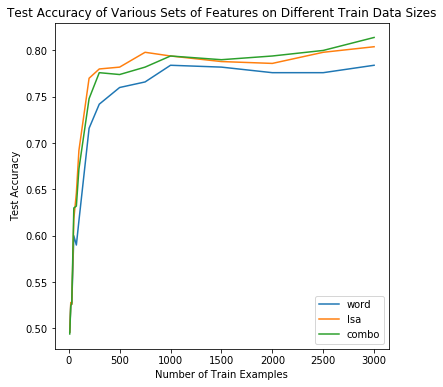

In [53]:
plt.figure(figsize=(6, 6))
plt.plot(train_sizes, word_500_results, label="word")
plt.plot(train_sizes, lsa_500_results, label="lsa")
plt.plot(train_sizes, combo_500_results, label="combo")
plt.legend(loc = "lower right")
plt.title('Test Accuracy of Various Sets of Features on Different Train Data Sizes')
plt.xlabel('Number of Train Examples')
plt.ylabel('Test Accuracy')

# plt.savefig('word_embed_matrix_e500.png')
# files.download('word_embed_matrix_e500.png')
plt.show()

In [0]:
embedding_sizes = [10, 50, 100, 500, 1000, 2000]
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

word_embed_results = {esz: {"word": [], "lsa": [], "combo": []} for esz in embedding_sizes}

for embed_sz in embedding_sizes:
    reps_tfidf = learn_reps_lsa(td_matrix_tfidf, embed_sz)
    
    word_results = word_embed_results[embed_sz]["word"]
    lsa_results = word_embed_results[embed_sz]["lsa"]
    combo_results = word_embed_results[embed_sz]["combo"]

    for n in train_sizes:
        word_results.append(training_experiment("word", word_featurizer, n, verbose=False))
        lsa_results.append(training_experiment("lsa", lsa_featurizer, n, verbose=False))
        combo_results.append(training_experiment("combo", combo_featurizer, n, verbose=False))

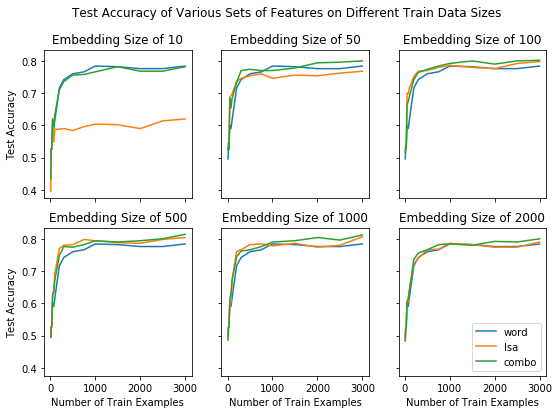

In [55]:
nrow = 2
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,6), sharex = True, sharey=True)
for i, embed_sz in enumerate(embedding_sizes):
    axs[i//ncol, i%ncol].plot(train_sizes, word_embed_results[embed_sz]["word"], label="word")
    axs[i//ncol, i%ncol].plot(train_sizes, word_embed_results[embed_sz]["lsa"], label="lsa")
    axs[i//ncol, i%ncol].plot(train_sizes, word_embed_results[embed_sz]["combo"], label="combo")
    axs[i//ncol, i%ncol].set_title('Embedding Size of {}'.format(embed_sz))

for ax in axs.flat:
    ax.set(xlabel='Number of Train Examples', ylabel='Test Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend(loc = "lower right")
plt.suptitle('Test Accuracy of Various Sets of Features on Different Train Data Sizes')
# plt.subplots_adjust(hspace=0.2)

# plt.savefig('assets/word_embed_matrix_embed-ntrain.png')
plt.show()

## Part 2: word representations via language modeling

In this section, we'll train a word embedding model with a word2vec-style objective rather than a matrix factorization objective. This requires a little more work; we've provided scaffolding for a PyTorch model implementation below.
(If you've never used PyTorch before, there are some tutorials [here](https://pytorch.org/tutorials/). You're also welcome to implement these experiments in
any other framework of your choosing.)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

class Word2VecModel(nn.Module):
  # A torch module implementing a word2vec predictor. The `forward` function
  # should take a batch of context word ids as input and predict the word 
  # in the middle of the context as output, as in the CBOW model from lecture.

  def __init__(self, vocab_size, embed_dim):
      super().__init__()

      # Your code here!
      self.vocab_size = vocab_size
      self.embed_dim = embed_dim
      self.V = nn.Embedding(vocab_size, embed_dim)
      self.U = nn.Linear(embed_dim, vocab_size)
      self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, context):
      # Context is an `n_batch x n_context` matrix of integer word ids
      # this function should return a set of scores for predicting the word 
      # in the middle of the context

      # Your code here!
      n_batch, n_context = context.shape
      embeddings = self.V(context)  # n_batch x n_context x self.embed_dim
      avg_context = torch.sum(embeddings, dim=1)
      output = self.U(avg_context)
      if not self.training:
        # training uses loss that incorporates softmax
        # apply softmax for prediction
        output = self.log_softmax(output)
      return output

In [0]:
def learn_reps_word2vec(corpus, window_size, rep_size, n_epochs, n_batch):
  # This method takes in a corpus of training sentences. It returns a matrix of
  # word embeddings with the same structure as used in the previous section of 
  # the assignment. (You can extract this matrix from the parameters of the 
  # Word2VecModel.)

  tokenizer = lab_util.Tokenizer()
  tokenizer.fit(corpus)
  tokenized_corpus = tokenizer.tokenize(corpus)

  ngrams = lab_util.get_ngrams(tokenized_corpus, window_size)

  device = torch.device('cuda')  # run on colab gpu
  model = Word2VecModel(tokenizer.vocab_size, rep_size).to(device)
  opt = optim.Adam(model.parameters(), lr=0.001)
  loss_fn = nn.CrossEntropyLoss()

  loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

  model.train()
  for epoch in range(n_epochs):
    for context, label in loader:
      # as described above, `context` is a batch of context word ids (n_batch, n_context), and
      # `label` is a batch of predicted word labels of shape (n_batch,)
      context = context.to(device)
      label = label.to(device)
      
      model.zero_grad()  # clear gradients
      preds = model(context)  # n_batch x vocab_size
      loss = loss_fn(preds, label)
      loss.backward()  # compute gradients
      opt.step()

  # reminder: you want to return a `vocab_size x embedding_size` numpy array
  embedding_matrix = model.V.weight.cpu().detach().numpy()
  return embedding_matrix

In [0]:
reps_word2vec = learn_reps_word2vec(train_reviews, 2, 500, 10, 100)

After training the embeddings, we can try to visualize the embedding space to see if it makes sense. First, we can take any word in the space and check its closest neighbors.

In [25]:
lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

good 47
  wide 1.683
  wouldn't 1.694
  tight 1.699
  scent 1.710
  slowly 1.740
bad 201
  inches 1.651
  done 1.654
  banana 1.670
  wanting 1.690
  weak 1.716
cookie 504
  he's 1.679
  caused 1.712
  substitute 1.716
  bit 1.733
  common 1.741
jelly 351
  received 1.696
  tomatoes 1.701
  formula 1.704
  canned 1.730
  seconds 1.738
dog 925
  german 1.703
  daily 1.708
  dark 1.713
  garbage 1.717
  worry 1.726
the 36
  a 1.516
  my 1.629
  mrs 1.708
  his 1.716
  another 1.734
4 292
  specifically 1.629
  earlier 1.684
  11 1.685
  packet 1.702
  reduced 1.705


We can also cluster the embedding space. Clustering in 4 or more dimensions is hard to visualize, and even clustering in 2 or 3 can be difficult because there are so many words in the vocabulary. One thing we can try to do is assign cluster labels and qualitiatively look for an underlying pattern in the clusters.

In [26]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec)
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1])
for token, cluster_idx in zipped:
  word = vectorizer.tokenizer.token_to_word[token]
  print(f"{word}: {cluster_idx}")

disappointed: 0
un: 0
fiber: 0
cubes: 1
general: 1
without: 1
kind: 1
him: 1
its: 1
still: 1
starbucks: 1
im: 2
spread: 2
change: 2
suggest: 2
bought: 2
go: 2
update: 2
learned: 2
mean: 2
description: 2
rate: 2
decide: 2
that's: 2
potassium: 3
plus: 3
target: 3
double: 3
moved: 4
below: 4
lunches: 4
filled: 4
given: 4
cookies: 4
needed: 4
artificial: 4
solid: 4
will: 4
zero: 4
buying: 5
amazing: 5
caffeine: 5
crackers: 5
expiration: 5
40: 5
unfortunately: 5
shipment: 5
next: 5
muffin: 6
brewer: 6
someone: 6
living: 6
calcium: 6
lasts: 6
teeth: 7
pieces: 7
prime: 7
beer: 7
months: 7
subtle: 7
ok: 7
help: 7
average: 7
bad: 7
has: 7
puppy: 7
something: 7
beef: 7
pouch: 7
doesn't: 7
granted: 7
we: 7
packing: 7
holes: 7
fall: 8
birthday: 8
seen: 9
caramels: 9
than: 9
large: 9
eaten: 9
hint: 9
excellent: 9
classic: 9
lays: 9
reviews: 9
worked: 9
nearly: 9
coffee: 9
times: 9
plum: 9
never: 9
treats: 9
morning: 9
fruit: 9
truly: 9
mill: 9
colors: 9
rica: 9


Finally, we can use the trained word embeddings to construct vector representations of full reviews. One common approach is to simply average all the word embeddings in the review to create an overall embedding. Implement the transform function in Word2VecFeaturizer to do this.

In [31]:
def word2vec_lsa_featurizer(xs):
  feats = xs@reps_word2vec # Your code here!

  # normalize
  return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

training_experiment("word2vec", word2vec_lsa_featurizer, 10)

word2vec features, 10 examples
test accuracy 0.532



**Part 2: Lab writeup**

Part 2 of your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Qualitatively, what do you observe about nearest neighbors in representation space? (E.g. what words are most similar to _the_, _dog_, _3_, and _good_?) How well do word2vec representations correspond to your intuitions about word similarity?

2. One important parameter in word2vec-style models is context size. How does changing the context size affect the kinds of representations that are learned?

3. How do results on the downstream classification problem compare to 
   part 1?

4. What are some advantages and disadvantages of learned embedding representations, relative to the featurization done in part 1?

5. What are some potential problems with constructing a representation of the review by averaging the embeddings of the individual words?

In [30]:
context_sizes = [1, 2, 3, 5, 10, 20, 30, 50]
for csz in context_sizes:
  print("Context window size: ", csz)
  reps_word2vec_test = learn_reps_word2vec(train_reviews, csz, 500, 10, 100)
  lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec_test, show_tokens)
  print()

Context window size:  1
good 47
  custard 1.651
  nice 1.699
  bland 1.702
  handy 1.704
  batches 1.709
bad 201
  cons 1.703
  messy 1.705
  inches 1.707
  pound 1.708
  pleasant 1.709
cookie 504
  personally 1.679
  highly 1.683
  boy 1.688
  support 1.693
  cholesterol 1.719
jelly 351
  zip 1.645
  strawberry 1.665
  dogs 1.697
  things 1.713
  training 1.714
dog 925
  vet 1.681
  serving 1.683
  china 1.689
  animal 1.715
  review 1.717
the 36
  my 1.588
  a 1.629
  their 1.651
  this 1.675
  effects 1.684
4 292
  30 1.643
  interested 1.653
  bills 1.677
  power 1.693
  directly 1.716

Context window size:  2
good 47
  suppose 1.697
  me 1.700
  by 1.702
  change 1.718
  rich 1.729
bad 201
  worth 1.709
  weird 1.714
  http 1.733
  bitter 1.735
  whatever 1.743
cookie 504
  review 1.709
  holds 1.714
  carbonated 1.745
  spices 1.748
  sounds 1.750
jelly 351
  mine 1.680
  broken 1.704
  hydrogenated 1.709
  reasonable 1.721
  each 1.727
dog 925
  pour 1.612
  bbq 1.708
  smell 1.

In [0]:
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

word2vec_500_results = []

reps_word2vec = learn_reps_word2vec(train_reviews, 2, 500, 10, 100)

for n in train_sizes:
    word2vec_500_results.append(training_experiment("word2vec", word2vec_lsa_featurizer, n, verbose=False))

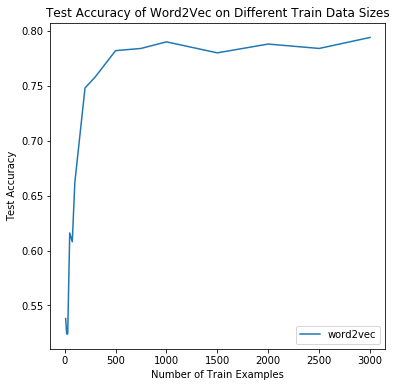

In [36]:
plt.figure(figsize=(6, 6))
plt.plot(train_sizes, word2vec_500_results, label="word2vec")
plt.legend(loc = "lower right")
plt.title('Test Accuracy of Word2Vec on Different Train Data Sizes')
plt.xlabel('Number of Train Examples')
plt.ylabel('Test Accuracy')

plt.savefig('word2vec_e500.png')
plt.show()

In [0]:
files.download('word2vec_e500.png')

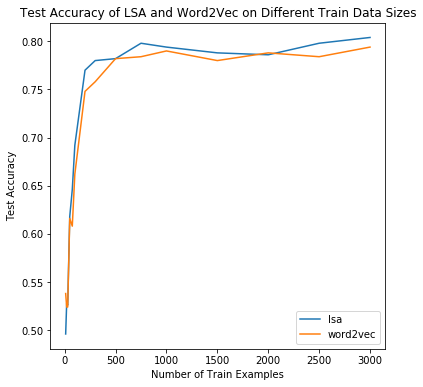

In [41]:
plt.figure(figsize=(6, 6))
plt.plot(train_sizes, lsa_500_results, label="lsa")
plt.plot(train_sizes, word2vec_500_results, label="word2vec")
plt.legend(loc = "lower right")
plt.title('Test Accuracy of LSA and Word2Vec on Different Train Data Sizes')
plt.xlabel('Number of Train Examples')
plt.ylabel('Test Accuracy')

plt.savefig('word2vec-vs-lsa_e500.png')
plt.show()

In [0]:
files.download('word2vec-vs-lsa_e500.png')

In [0]:
embedding_sizes = [10, 50, 100, 500, 1000, 2000]
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

word2vec_results = {esz: [] for esz in embedding_sizes}

for embed_sz in embedding_sizes:
    reps_word2vec = learn_reps_word2vec(train_reviews, 2, embed_sz, 10, 100)

    for n in train_sizes:
        word2vec_results[embed_sz].append(training_experiment("word2vec", word2vec_lsa_featurizer, n, verbose=False))

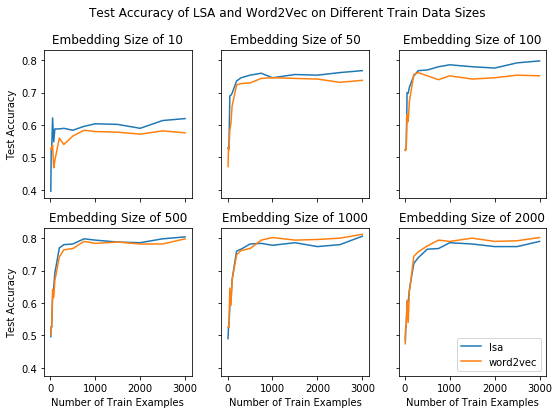

In [58]:
nrow = 2
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,6), sharex = True, sharey=True)
for i, embed_sz in enumerate(embedding_sizes):
    axs[i//ncol, i%ncol].plot(train_sizes, word_embed_results[embed_sz]["lsa"], label="lsa")
    axs[i//ncol, i%ncol].plot(train_sizes, word2vec_results[embed_sz], label="word2vec")
    axs[i//ncol, i%ncol].set_title('Embedding Size of {}'.format(embed_sz))

for ax in axs.flat:
    ax.set(xlabel='Number of Train Examples', ylabel='Test Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend(loc = "lower right")
plt.suptitle('Test Accuracy of LSA and Word2Vec on Different Train Data Sizes')
# plt.subplots_adjust(hspace=0.2)

plt.savefig('lsa-word2vec_embed-ntrain.png')
files.download('lsa-word2vec_embed-ntrain.png')
plt.show()